In [66]:
import numpy as np
import pandas as pd
import os
import glob
import json
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

%matplotlib inline

In [67]:
trained_models_dir = "/cluster/tufts/hugheslab/prath01/results/semi-synthetic_eicu/skorch_logistic_regression"
training_files = glob.glob(os.path.join(trained_models_dir, '*surrogate_loss_tight*history.json'))
training_perf_csvs = glob.glob(os.path.join(trained_models_dir, '*surrogate_loss_tight*_perf.csv'))

In [68]:
len(training_perf_csvs)

336

0.2023121387283237

In [69]:
n_epochs=200
train_losses_np = np.zeros((len(training_files), n_epochs))+np.nan
train_g_theta_np = np.zeros((len(training_files), n_epochs))+np.nan
train_f_theta_np = np.zeros((len(training_files), n_epochs))+np.nan
train_precision_np = np.zeros((len(training_files), n_epochs))+np.nan
train_recall_np = np.zeros((len(training_files), n_epochs))+np.nan
train_tp_np = np.zeros((len(training_files), n_epochs))+np.nan
train_tpl_bound_np = np.zeros((len(training_files), n_epochs))+np.nan
train_fp_np = np.zeros((len(training_files), n_epochs))+np.nan
train_fpu_bound_np = np.zeros((len(training_files), n_epochs))+np.nan
lamb_vals_np = np.zeros(len(training_files))+np.nan
training_files_keep_inds = False*np.ones(len(training_files))+np.nan
final_precisions_np = np.zeros(len(training_files))
final_recalls_np = np.zeros(len(training_files))

for ii, training_hist_json in enumerate(training_files):
    training_perf_csv = training_hist_json.replace('history.json', '_perf.csv')
    training_hist_df = pd.DataFrame(json.load(open(training_hist_json)))
    training_perf_df = pd.read_csv(training_perf_csv)
    hist_len = max(training_hist_df['epoch'])
    if hist_len<=200:
        train_losses_np[ii, :hist_len] = training_hist_df['train_loss']
        train_g_theta_np[ii, :hist_len] = training_hist_df['g_theta_train']
        train_f_theta_np[ii, :hist_len] = -training_hist_df['tpl_bound_train']
        train_precision_np[ii, :hist_len] = training_hist_df['precision_train']
        train_recall_np[ii, :hist_len] = training_hist_df['recall_train']
        train_tp_np[ii, :hist_len] = training_hist_df['tp_train']
        train_tpl_bound_np[ii, :hist_len] = training_hist_df['tpl_bound_train']
        train_fp_np[ii, :hist_len] = training_hist_df['fp_train']
        train_fpu_bound_np[ii, :hist_len] = training_hist_df['fpu_bound_train']
        cur_param_list = training_hist_json.split('-')
        try:
            lamb_vals_np[ii] = float([j for j in cur_param_list if 'lamb' in j][0].split('lamb=')[-1])
        except:
            lamb_vals_np[ii] = float(training_hist_json.split('lamb=')[-1].split('-')[0]+'-'+training_hist_json.split('lamb=')[-1].split('-')[1])
        training_files_keep_inds[ii] = True
        final_precisions_np[ii] = training_perf_df['precision_train'][0]
        final_recalls_np[ii] = training_perf_df['recall_train'][0]
        

In [9]:
np.unique(lamb_vals_np)

array([1.e-02, 5.e-02, 1.e-01, 5.e-01, 1.e+00, 5.e+00, 1.e+01, 5.e+01,
       1.e+02, 5.e+02, 1.e+03, 5.e+03, 1.e+04, 5.e+04])

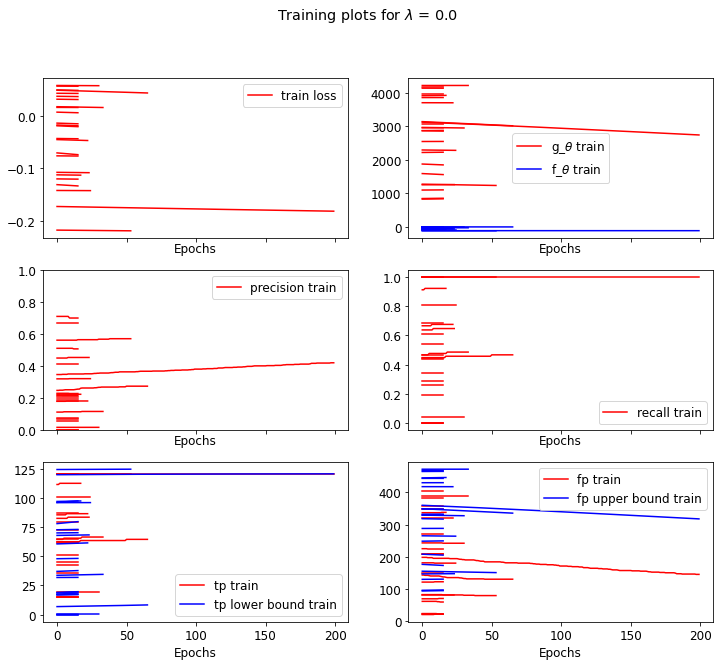

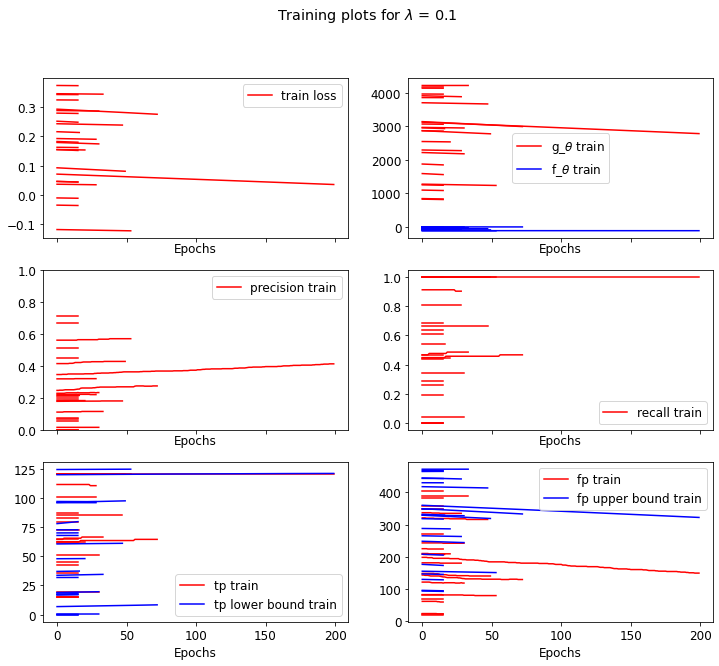

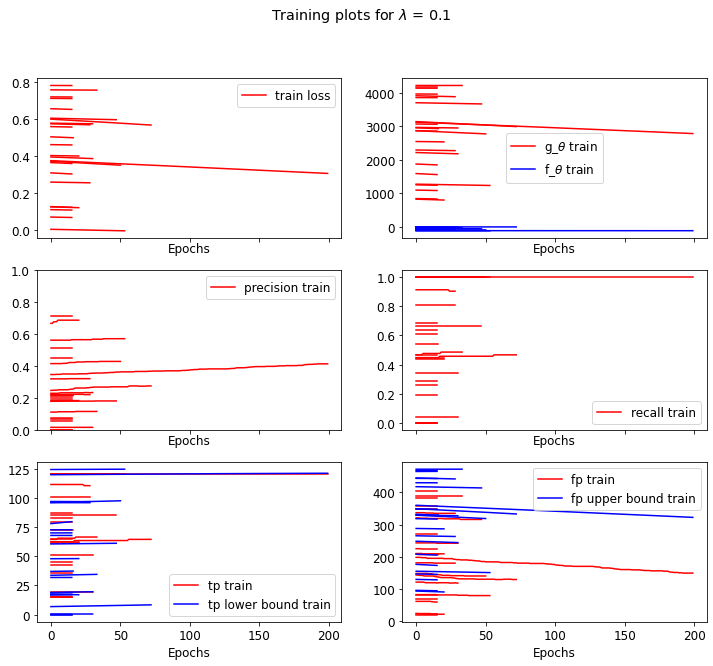

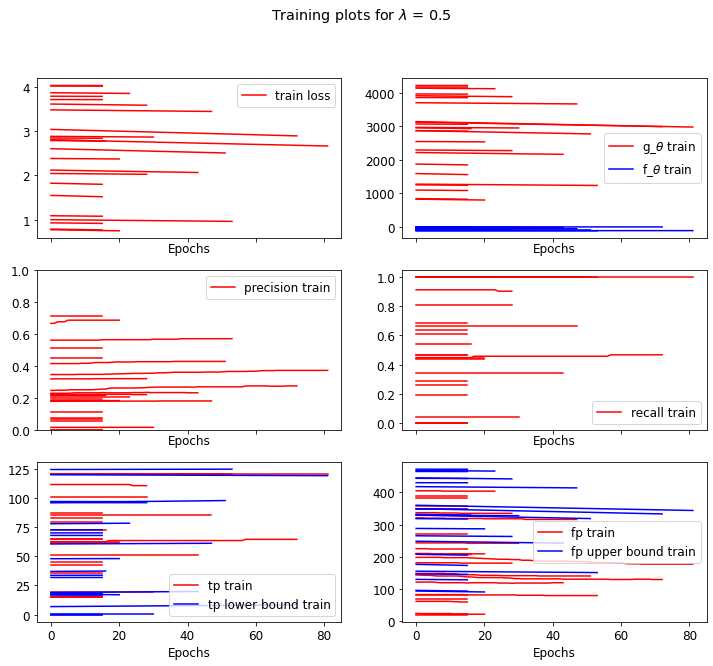

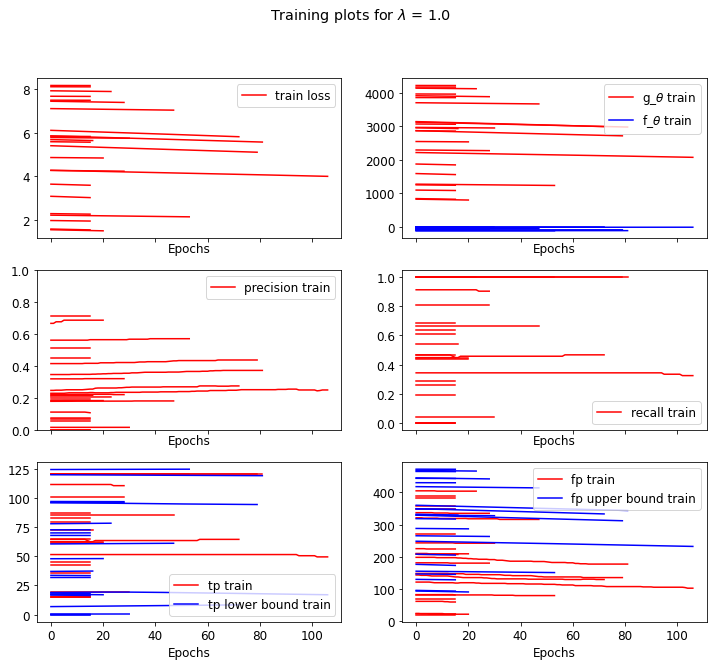

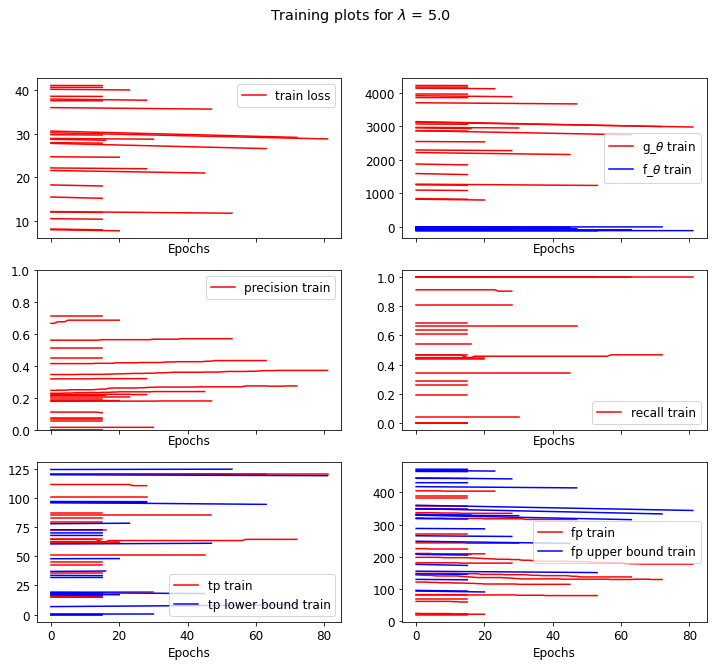

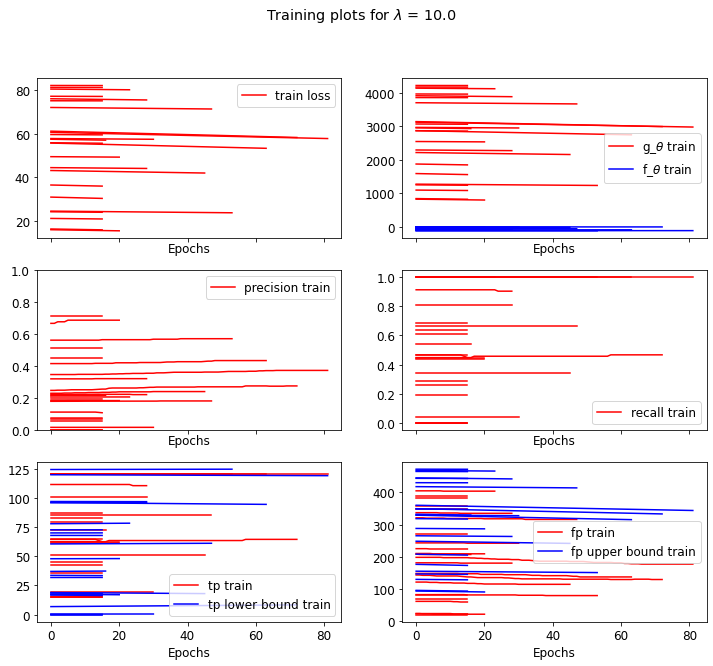

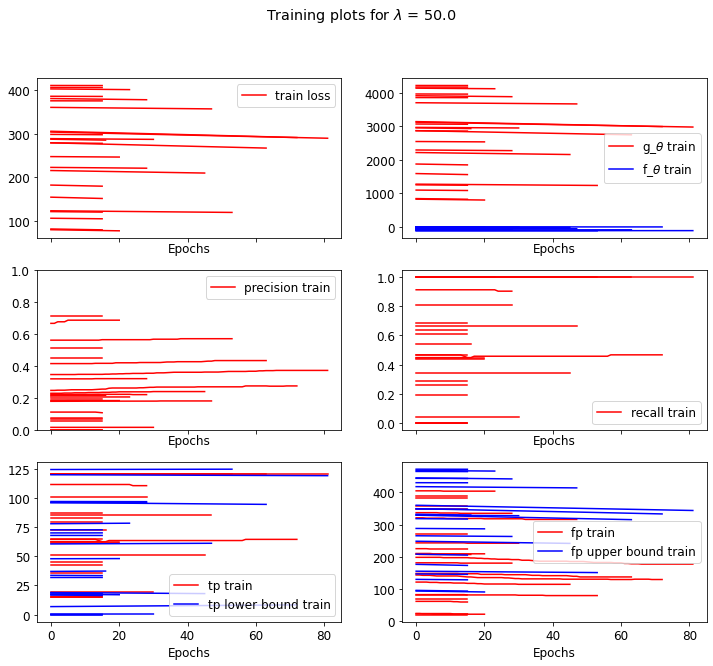

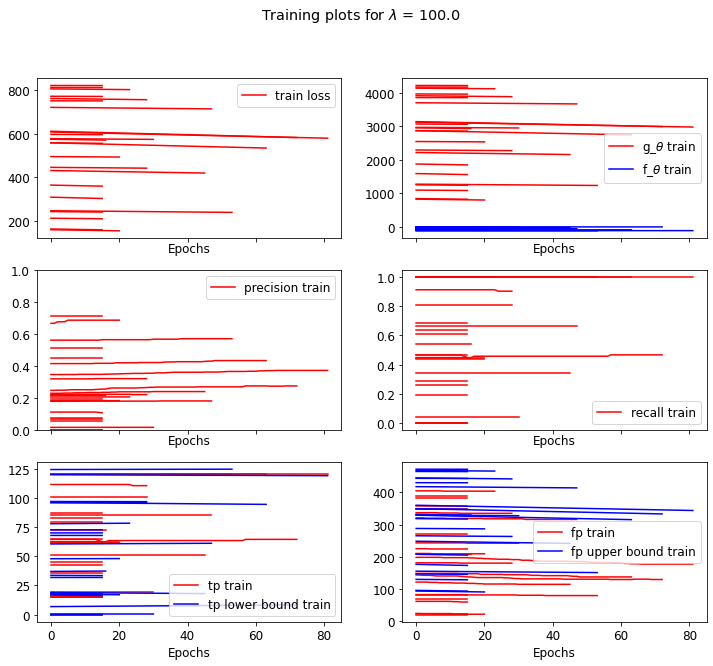

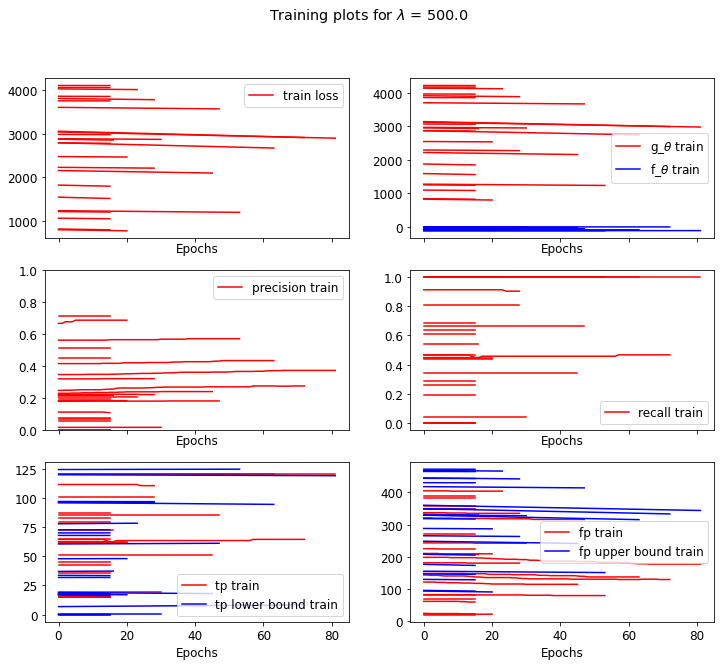

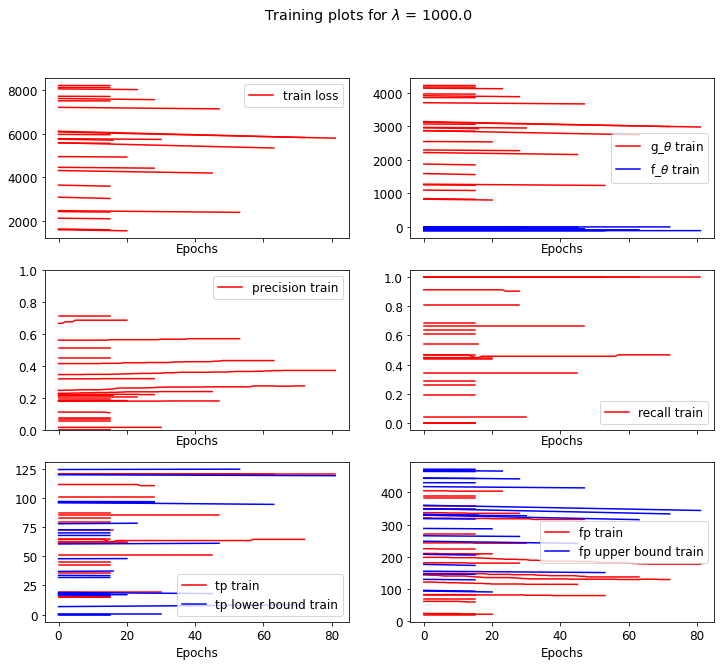

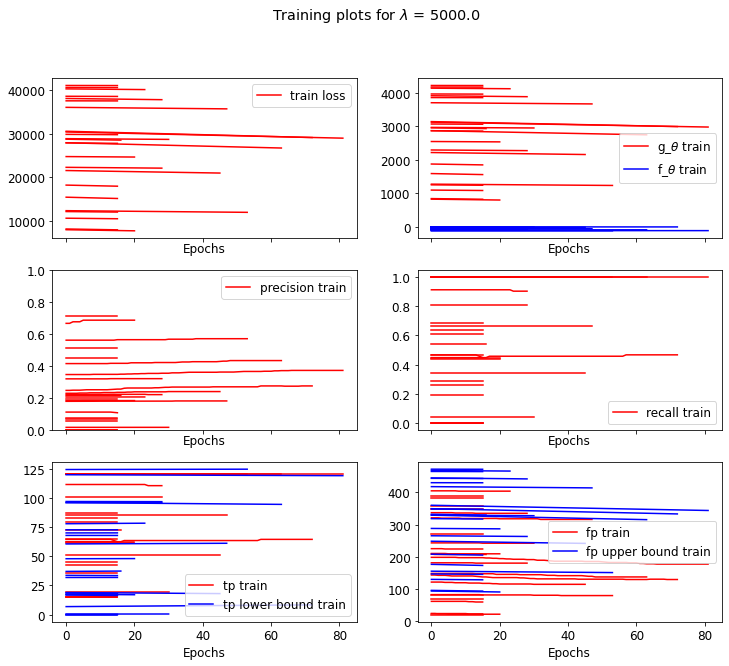

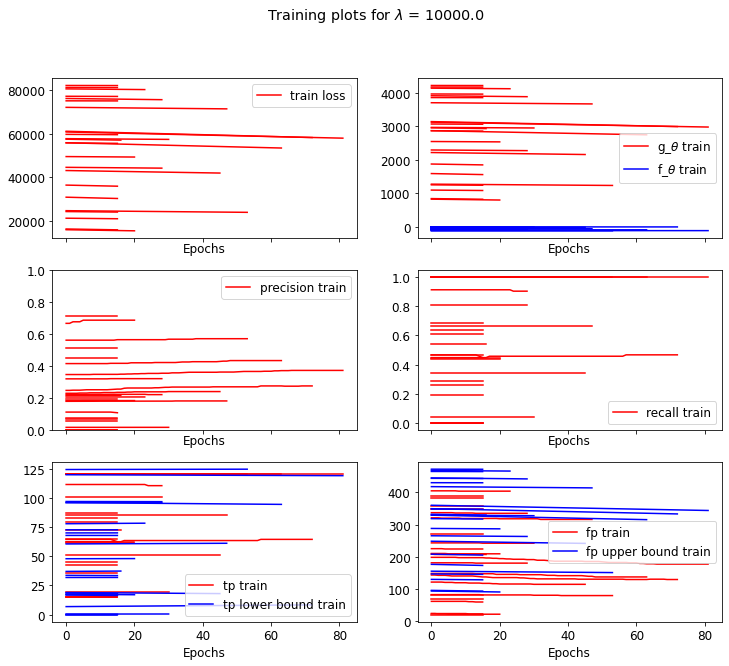

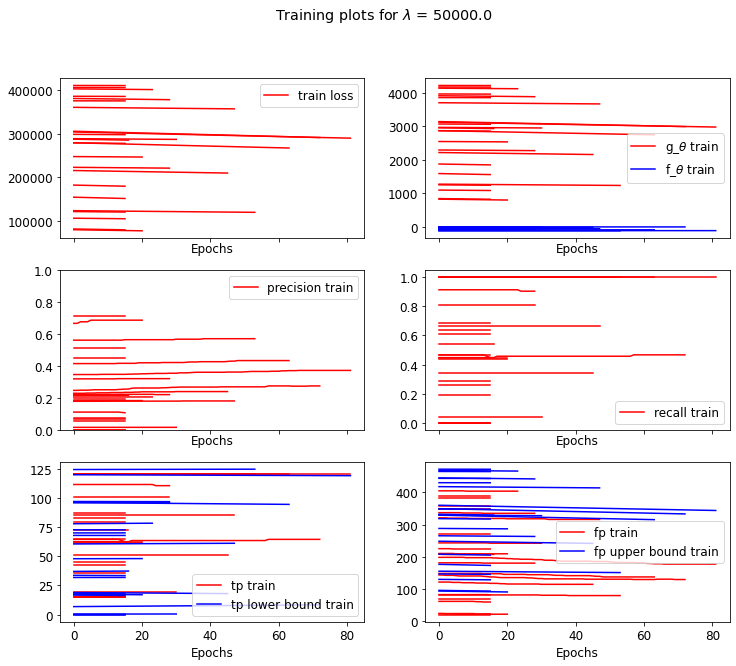

In [73]:
final_train_precisions = train_precision_np[:, -1]
unique_lambs = np.unique(lamb_vals_np)

for lamb in unique_lambs:
    keep_inds = (lamb_vals_np>=lamb-1e-15)&(lamb_vals_np<=lamb+1e-15)

    # plot epochs, train loss, (g_theta, -tpl_bound_train), precision, recall, (tp_train, tpl_bound_train), (fp_train, fpu_bound_train)
    f, axs = plt.subplots(3, 2, sharex=True, figsize=(12, 10))
    axs_list = axs.flatten()
    
    
    plt.rcParams['font.size'] = 12
    
    epochs = np.arange(n_epochs)
    axs_list[0].plot(epochs, train_losses_np[keep_inds].T, color = 'r', label='train loss')

    axs_list[1].plot(epochs, train_g_theta_np[keep_inds].T, color = 'r', label=r'g_$\theta$ train')
    axs_list[1].plot(epochs, train_f_theta_np[keep_inds].T, color = 'b', label=r'f_$\theta$ train')

    axs_list[2].plot(epochs, train_precision_np[keep_inds].T, color = 'r', label='precision train')
    axs_list[2].set_ylim([0., 1.])
    axs_list[3].plot(epochs, train_recall_np[keep_inds].T, color = 'r', label='recall train')

    axs_list[4].plot(epochs, train_tp_np[keep_inds].T, color = 'r', label='tp train')
    axs_list[4].plot(epochs, train_tpl_bound_np[keep_inds].T, color = 'b', label='tp lower bound train')

    axs_list[5].plot(epochs, train_fp_np[keep_inds].T, color = 'r', label='fp train')
    axs_list[5].plot(epochs, train_fpu_bound_np[keep_inds].T, color = 'b', label='fp upper bound train')

    for ax in axs_list:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        ax.set_xlabel('Epochs')
    
    plt.suptitle(r'Training plots for $\lambda$ = %.1f'%lamb)
#     f.savefig('EICU_semi_synthetic_training_plots_lamb_%s.png'%lamb)
    
    plt.show()
    
    
    

In [71]:
max(final_precisions_np)

0.7101449275362319

In [33]:
lamb_vals_np[0]==unique_lambs

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [29]:
np.unique(lamb_vals_np)[0]

0.01

In [31]:
unique_lambs = np.unique(lamb_vals_np)

In [38]:
keep_inds = (lamb_vals_np>=unique_lambs[0]-1e-15)&(lamb_vals_np<=unique_lambs[0]+1e-15)
train_losses_np[keep_inds].shape

(103, 350)

1443

TypeError: only integer scalar arrays can be converted to a scalar index

(1443,)